In [56]:
import torch

In [58]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [62]:
class NNQS(nn.Module):
    def __init__(self):
        super(NNQS, self).__init__()
        self.fc1_u = nn.Linear(1, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 1)
        #self.fc4_u = nn.Linear(50, 1)
        #self.fc5_u = nn.Linear(20, 20)
        #self.fc6_u = nn.Linear(20, 1)

    def forward(self, x):
        u = F.softplus(self.fc1_u(x))
        u = F.softplus(self.fc2_u(u))
        #u = F.softplus(self.fc3_u(u))
        #u = torch.tanh(self.fc4_u(u))
        #u = torch.tanh(self.fc5_u(u))
        u = self.fc3_u(u)
        return u

# Initialize model
model = NNQS().to(device)


In [64]:
# Ensure CUDA context initialization
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization


In [66]:
x = torch.linspace(-10,10,20001).to(device)
x.requires_grad = True
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization

In [68]:
x = x.reshape(-1,1)
x

tensor([[-10.0000],
        [ -9.9990],
        [ -9.9980],
        ...,
        [  9.9980],
        [  9.9990],
        [ 10.0000]], device='cuda:0', grad_fn=<ViewBackward0>)

In [70]:
x[1]-x[0]

tensor([0.0010], device='cuda:0', grad_fn=<SubBackward0>)

In [72]:
model(x)

tensor([[-0.0008],
        [-0.0008],
        [-0.0008],
        ...,
        [ 0.2397],
        [ 0.2397],
        [ 0.2397]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [74]:
def HpsiH(x,model):
    u = model(x)
    u1 = u.reshape(-1)
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    return (torch.sum((-u_xx*u1+(4.0)*(x1**2)*(u1**2)))*0.001)**2

In [76]:
def normalization(x,model):
    u = model(x)
    return 1000*((torch.sum(u**2)*0.001 - torch.tensor(1.0))**2)

In [78]:
eta = 0.001
optimizer = optim.Adam(list(model.parameters()), lr=eta)

In [82]:
for epoch in range(10000):
    E_loss = HpsiH(x,model)
    norm_loss = normalization(x,model)            
    optimizer.zero_grad()
    L_total = E_loss + norm_loss
    
    # Step 3: Backpropagate to compute gradients
    L_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{L_total}")

epochs:100 , Loss:4.248057842254639
epochs:200 , Loss:4.240575313568115
epochs:300 , Loss:4.233349323272705
epochs:400 , Loss:4.226335048675537
epochs:500 , Loss:4.219505310058594
epochs:600 , Loss:4.212836742401123
epochs:700 , Loss:4.206304550170898
epochs:800 , Loss:4.19989538192749
epochs:900 , Loss:4.19357442855835
epochs:1000 , Loss:4.187331676483154
epochs:1100 , Loss:4.181150913238525
epochs:1200 , Loss:4.1750335693359375
epochs:1300 , Loss:4.168966293334961
epochs:1400 , Loss:4.162945747375488
epochs:1500 , Loss:4.156970024108887
epochs:1600 , Loss:4.1510419845581055
epochs:1700 , Loss:4.145161151885986
epochs:1800 , Loss:4.1393327713012695
epochs:1900 , Loss:4.133563041687012
epochs:2000 , Loss:4.127858638763428
epochs:2100 , Loss:4.122225284576416
epochs:2200 , Loss:4.116672992706299
epochs:2300 , Loss:4.111207008361816
epochs:2400 , Loss:4.10584020614624
epochs:2500 , Loss:4.100577354431152
epochs:2600 , Loss:4.095429420471191
epochs:2700 , Loss:4.090394973754883
epochs:280

In [114]:
u_pred = model(x).reshape(-1)

In [116]:
u_pred

tensor([ 0.0003,  0.0003,  0.0003,  ..., -0.0008, -0.0008, -0.0008],
       device='cuda:0', grad_fn=<ViewBackward0>)

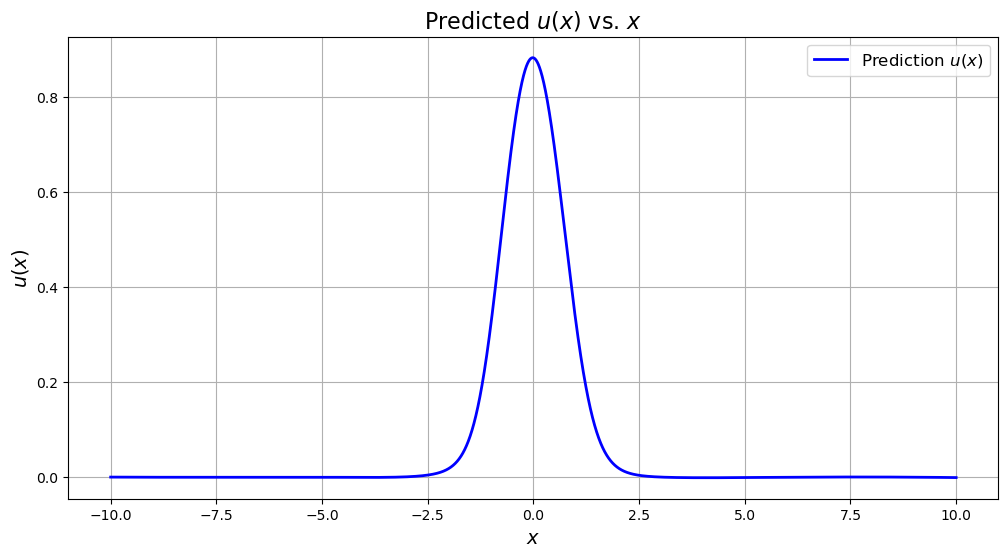

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming u_pred is already converted to a numpy array
u_pred = u_pred.detach().cpu().numpy()

# Create x_array
x_array = np.linspace(-10, 10, 20001)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_array, u_pred, label='Prediction $u(x)$', color='blue', linewidth=2)

# Add labels, title, and legend
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.title('Predicted $u(x)$ vs. $x$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [128]:
u = model(x)

In [129]:
HpsiH(x,model)/(torch.sum(u**2)*0.001)

tensor(3.9974, device='cuda:0', grad_fn=<DivBackward0>)

In [130]:
(torch.sum(u**2)*0.001)

tensor(0.9960, device='cuda:0', grad_fn=<MulBackward0>)

In [134]:
u = model(x)
grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_x = grads[:,0]
u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
u_xx = u_x_grads[:,0]

In [42]:
A = (-u_xx + 100*(x1**2)*(u1))
A.shape

torch.Size([20001])

In [ ]:
A = 100*(x1**2)*(u1)
A.shape

In [ ]:
torch.sum(u**2)

In [124]:
normalization(x,model)

tensor(0.0159, device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=20)

In [ ]:
for epoch in range(100):
    def closure():
        optimizer.zero_grad()

        # Compute losses
        E_loss = HpsiH(x,model)
        norm_loss = normalization(x,model)            
        L_total = E_loss + norm_loss
        
        # Backpropagation
        L_total.backward()
        return L_total

    optimizer.step(closure)

    # Print loss every 100 epochs
    if epoch % 10 == 9:
        loss = closure()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


In [136]:
u1 = u.reshape(-1)
x1 = x.reshape(-1)

In [138]:
torch.sum((-u_xx*u1+(4.0)*(x1**2)*(u1**2)))*0.001

tensor(1.9954, device='cuda:0', grad_fn=<MulBackward0>)

In [122]:
(torch.sum((-u_xx*u1+(4.0)*(x1**2)*(u1**2)))*0.001)

tensor(0.2842, device='cuda:0', grad_fn=<MulBackward0>)

In [126]:
HpsiH(x,model)

tensor(3.9815, device='cuda:0', grad_fn=<PowBackward0>)